## Unet
using https://github.com/petrosgk/Kaggle-Carvana-Image-Masking-Challenge/blob/master/model/u_net.py
as starter code by recommendation of Trupesh

In [2]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
import keras
from keras import backend as K
from losses import bce_dice_loss, dice_loss, weighted_bce_dice_loss, weighted_dice_loss, dice_coeff
from keras.applications.vgg16 import preprocess_input, VGG16

In [3]:
#K.set_image_dim_ordering('th')
input_shape=(256,256,3)


num_classes=1


In [5]:

from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                     zoom_range=0.2,
                     rescale=1./255,
                     preprocessing_function=preprocess_input
                    )
mdata_gen_args = dict(rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     horizontal_flip=True,
                     vertical_flip=True,
                    rescale=1./255,
                     zoom_range=0.2)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**mdata_gen_args)

seed = 1
bs=10


image_generator = image_datagen.flow_from_directory(
    '/data/user/wsmonroe/Opthamology/neuralNetTest/data',
    seed=seed,
    batch_size=bs,
    target_size=(256, 256)
    )

mask_generator = mask_datagen.flow_from_directory(
    '/data/user/wsmonroe/Opthamology/neuralNetTest/gtdata',
    seed=seed,
    batch_size=bs,
    color_mode='grayscale',
    target_size=(256,256))

#next(image_generator)

def combine_generator(gen1,gen2):
    while True:

        X = gen1.next()
        y = gen2.next()

        yield(X[0],y[0])

train_generator = combine_generator(image_generator,mask_generator)#zip(image_generator, mask_generator)

Found 109 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [6]:
import numpy as np
#base_model=keras.applications.inception_resnet_v2.InceptionResNetV2(include_top = False,weights='imagenet',input_shape=input_shape)
#for layer in base_model.layers:
#    layer.trainable = False
    #print(layer.name)
#base_model.summary()
a, b = next(train_generator)
print(np.max(np.max(a)))
print(np.min(np.min(a)))
print(np.max(np.max(b)))
print(np.min(np.min(b)))

0.59239614
-0.4497255
1.0
0.0


In [65]:
inputs = Input(shape=input_shape)
# 256

down0 = Conv2D(32, (3, 3), padding='same')(inputs)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv2D(32, (3, 3), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)
# 128

down1 = Conv2D(64, (3, 3), padding='same')(down0_pool)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1 = Conv2D(64, (3, 3), padding='same')(down1)
down1 = BatchNormalization()(down1)
down1 = Activation('relu')(down1)
down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
# 64

down2 = Conv2D(128, (3, 3), padding='same')(down1_pool)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2 = Conv2D(128, (3, 3), padding='same')(down2)
down2 = BatchNormalization()(down2)
down2 = Activation('relu')(down2)
down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
# 32

down3 = Conv2D(256, (3, 3), padding='same')(down2_pool)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3 = Conv2D(256, (3, 3), padding='same')(down3)
down3 = BatchNormalization()(down3)
down3 = Activation('relu')(down3)
down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
# 16

down4 = Conv2D(512, (3, 3), padding='same')(down3_pool)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4 = Conv2D(512, (3, 3), padding='same')(down4)
down4 = BatchNormalization()(down4)
down4 = Activation('relu')(down4)
down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
# 8

center = Conv2D(1024, (3, 3), padding='same')(down4_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)
# center

up4 = UpSampling2D((2, 2))(center)
up4 = concatenate([down4, up4], axis=3)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
up4 = Conv2D(512, (3, 3), padding='same')(up4)
up4 = BatchNormalization()(up4)
up4 = Activation('relu')(up4)
# 16

up3 = UpSampling2D((2, 2))(up4)
up3 = concatenate([down3, up3], axis=3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
up3 = Conv2D(256, (3, 3), padding='same')(up3)
up3 = BatchNormalization()(up3)
up3 = Activation('relu')(up3)
# 32

up2 = UpSampling2D((2, 2))(up3)
up2 = concatenate([down2, up2], axis=3)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
up2 = Conv2D(128, (3, 3), padding='same')(up2)
up2 = BatchNormalization()(up2)
up2 = Activation('relu')(up2)
# 64

up1 = UpSampling2D((2, 2))(up2)
up1 = concatenate([down1, up1], axis=3)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
up1 = Conv2D(64, (3, 3), padding='same')(up1)
up1 = BatchNormalization()(up1)
up1 = Activation('relu')(up1)
# 128

up0 = UpSampling2D((2, 2))(up1)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
# 256

classify = Conv2D(1, (1, 1), activation='sigmoid')(up0)

model = Model(inputs=inputs, outputs=classify)

model.compile(optimizer=RMSprop(lr=0.001), loss=dice_loss, metrics=[dice_coeff])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 256, 256, 32) 128         conv2d_29[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 256, 256, 32) 0           batch_normalization_28[0][0]     
__________________________________________________________________________________________________
conv2d_30 

In [66]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard


epochs = 50
batch_size = 1

callbacks = [EarlyStopping(monitor='loss',
                           patience=8,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               min_delta=1e-4),
             ModelCheckpoint(monitor='loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='logs')]

#next(train_generator)

In [67]:

results = model.fit_generator(train_generator,
                    steps_per_epoch=100/(bs+1),
                    workers=8,
                    epochs=100,
                    verbose=1)


Epoch 1/100
50/50 [==============================] - 14s 283ms/step - loss: 0.8657 - dice_coeff: 0.1343
Epoch 2/100
50/50 [==============================] - 10s 191ms/step - loss: 0.8466 - dice_coeff: 0.1534
Epoch 3/100
50/50 [==============================] - 10s 192ms/step - loss: 0.8380 - dice_coeff: 0.1620
Epoch 4/100
50/50 [==============================] - 10s 191ms/step - loss: 0.8222 - dice_coeff: 0.1778
Epoch 5/100
50/50 [==============================] - 10s 191ms/step - loss: 0.8172 - dice_coeff: 0.1828
Epoch 6/100
50/50 [==============================] - 10s 193ms/step - loss: 0.8103 - dice_coeff: 0.1897
Epoch 7/100
50/50 [==============================] - 10s 191ms/step - loss: 0.8005 - dice_coeff: 0.1995
Epoch 8/100
50/50 [==============================] - 10s 193ms/step - loss: 0.8018 - dice_coeff: 0.1982
Epoch 9/100
50/50 [==============================] - 10s 192ms/step - loss: 0.7894 - dice_coeff: 0.2106
Epoch 10/100
50/50 [==============================] - 10s 191ms/

50/50 [==============================] - 10s 191ms/step - loss: 0.7580 - dice_coeff: 0.2420
Epoch 90/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7498 - dice_coeff: 0.2502
Epoch 91/100
50/50 [==============================] - 10s 192ms/step - loss: 0.7505 - dice_coeff: 0.2495
Epoch 92/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7564 - dice_coeff: 0.2436
Epoch 93/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7603 - dice_coeff: 0.2397
Epoch 94/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7567 - dice_coeff: 0.2433
Epoch 95/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7582 - dice_coeff: 0.2418
Epoch 96/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7607 - dice_coeff: 0.2393
Epoch 97/100
50/50 [==============================] - 10s 191ms/step - loss: 0.7580 - dice_coeff: 0.2420
Epoch 98/100
50/50 [==============================] - 10s 192ms/step

In [68]:
from keras.preprocessing.image import ImageDataGenerator

vdata_gen_args = dict(horizontal_flip=False,
                     vertical_flip=False,
                     rescale=1./255,
                     preprocessing_function=preprocess_input)
mvdata_gen_args = dict(horizontal_flip=False,
                     rescale=1./255,
                     vertical_flip=False)
vimage_datagen = ImageDataGenerator(**vdata_gen_args)
vmask_datagen = ImageDataGenerator(**mvdata_gen_args)

seed = 1
bs=1


vimage_generator = vimage_datagen.flow_from_directory(
    '/data/user/wsmonroe/Opthamology/neuralNetTest/data',
    seed=seed,
    batch_size=bs,
    color_mode='rgb',
    shuffle=False,
    target_size=(256, 256))

vmask_generator = vmask_datagen.flow_from_directory(
    '/data/user/wsmonroe/Opthamology/neuralNetTest/gtdata',
    seed=seed,
    batch_size=bs,
    color_mode='grayscale',
    shuffle=False,
    target_size=(256, 256))

validation_generator = combine_generator(vimage_generator,vmask_generator)#zip(image_generator, mask_generator)

Found 109 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [69]:
import matplotlib.pyplot as plt
import numpy as np
def predict_one():
    image_batch, mask_batch = next(validation_generator)
    predicted_mask_batch = model.predict(image_batch)
    image = image_batch[0]/255
    print(image.shape)
    predicted_mask = predicted_mask_batch[0].reshape((256,256,1))
    '''predicted_mask[:,:,0] = predicted_mask[:,:,0] < 0.5
    predicted_mask[:,:,1] = predicted_mask[:,:,1] < 0.5
    predicted_mask[:,:,2] = predicted_mask[:,:,2] < 0.5'''
    print(predicted_mask.shape)
    print(np.max(np.max(image)))
    print(np.min(np.min(image)))
    print(np.max(np.max(predicted_mask)))
    print(np.min(np.min(predicted_mask)))

    plt.imshow(image[:,:,0])
    plt.imshow(predicted_mask[:,:,0], alpha=0.5)

(256, 256, 3)
(256, 256, 1)
0.0023231222
-0.00091780093
1.0
6.664786e-14


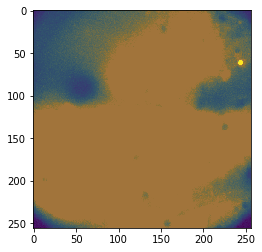

In [103]:
predict_one()


